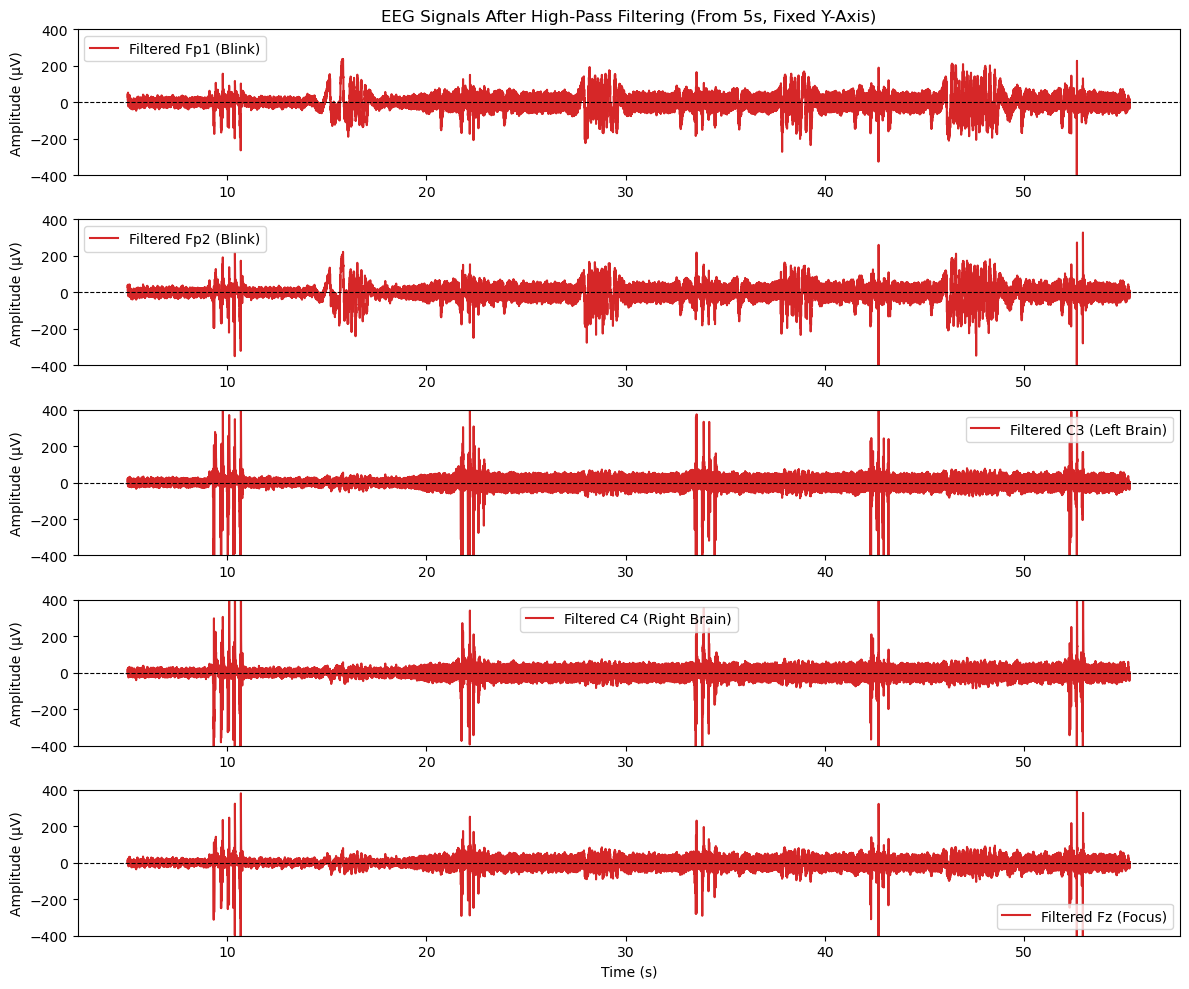

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# 📂 Load EEG Data
eeg_data = np.load("data/misc/eeg_run-1.npy")
fs = 250  # Sampling rate (Hz)
num_samples = eeg_data.shape[1]

# 🛑 Ignore first 5 seconds
start_idx = fs * 5  
time_axis = np.arange(start_idx, num_samples) / fs  # Time in seconds (from 5s onward)

# 🎛 High-Pass Filter Design (1 Hz cutoff)
def highpass_filter(data, cutoff=1.0, fs=250, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="high", analog=False)
    return filtfilt(b, a, data)

# 🎯 Select Key EEG Channels (Fp1, Fp2, C3, C4, Fz)
channel_names = ["Fp1 (Blink)", "Fp2 (Blink)", "C3 (Left Brain)", "C4 (Right Brain)", "Fz (Focus)"]
channel_indices = [2, 3, 0, 1, 4]  # Corresponding indices in OpenBCI Cyton

# 🧠 Apply High-Pass Filter & Slice Data from 5s Onward
filtered_signals = {name: highpass_filter(eeg_data[idx])[start_idx:] for name, idx in zip(channel_names, channel_indices)}

# 📊 Plot EEG Signals for Each Channel (Starting from 5s)
plt.figure(figsize=(12, 10))

for i, (name, signal) in enumerate(filtered_signals.items()):
    plt.subplot(5, 1, i + 1)
    plt.plot(time_axis, signal, label=f"Filtered {name}", color="tab:red")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line at 0
    plt.ylim(-400, 400)  # 🔥 Fixed y-axis range
    plt.legend()
    plt.ylabel("Amplitude (µV)")
    if i == 0:
        plt.title("EEG Signals After High-Pass Filtering (From 5s, Fixed Y-Axis)")
    if i == 4:
        plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()

In [4]:
filtered_eeg = highpass_filter(eeg_data)

# 🛑 Ignore first 5 seconds
start_idx = fs * 5  
filtered_data = filtered_eeg[:, start_idx:]  # Use only from 5s onward

# 🔍 Select Key EEG Channels
fp1 = np.abs(filtered_data[2])  # Blink detection (Fp1)
fp2 = np.abs(filtered_data[3])  # Blink detection (Fp2)
c3 = np.abs(filtered_data[0])  # Left brain (Movement)
c4 = np.abs(filtered_data[1])  # Right brain (Movement)
fz = np.abs(filtered_data[4])  # Focus level

# 📌 **1. Blink Threshold Calculation** (Using 98th percentile)
blink_threshold_fp1 = np.percentile(fp1, 98)  # Fp1 (Left Eye Blink)
blink_threshold_fp2 = np.percentile(fp2, 98)  # Fp2 (Right Eye Blink)
blink_threshold = max(blink_threshold_fp1, blink_threshold_fp2)  # Use the highest

print(f"🔵 Suggested Blink Threshold: {blink_threshold:.2f} µV")

# 📌 **2. Movement Threshold Calculation** (Left vs Right Brain)
left_activity = np.percentile(c3, 5)  # Lower percentile ensures continuous movement
right_activity = np.percentile(c4, 5)

movement_threshold = min(left_activity, right_activity)  # Use the lowest for sensitivity

print(f"🟠 Suggested Movement Threshold: {movement_threshold:.2f} µV")

# 📌 **3. Focus Threshold Calculation** (Fz Channel)
baseline_focus = np.percentile(fz, 85)  # Higher percentile ensures selective acceleration
focus_threshold = max(baseline_focus, 1.5 * movement_threshold)  # Ensures focus > movement

print(f"🟢 Suggested Focus Threshold for Acceleration: {focus_threshold:.2f} µV")

🔵 Suggested Blink Threshold: 142.49 µV
🟠 Suggested Movement Threshold: 2.61 µV
🟢 Suggested Focus Threshold for Acceleration: 44.84 µV
